# Dataset Deret Waktu untuk Prediksi

## Pengambilan Data NO₂ Sentinel-5P di Wilayah Sumenep melalui openEO

Kode berikut digunakan untuk mengunduh data konsentrasi **Nitrogen Dioksida (NO₂)** dari satelit **Sentinel-5P** menggunakan platform **openEO**. Dataset ini bertujuan untuk menganalisis kondisi kualitas udara di wilayah Sumenep dalam rentang waktu tertentu.

Langkah-langkah prosesnya meliputi:

1. **Autentikasi ke openEO**
   Tahap awal dilakukan proses login ke endpoint `openeo.dataspace.copernicus.eu` menggunakan protokol **OIDC (OpenID Connect)** agar pengguna dapat mengakses dataset Sentinel-5P.

2. **Penentuan Area Penelitian (AOI)**
   Area of Interest (AOI) ditentukan dalam bentuk poligon berisi koordinat lintang dan bujur yang merepresentasikan wilayah administratif Sumenep. Area ini menjadi fokus utama pengambilan data satelit.

3. **Pemanggilan Koleksi Data Sentinel-5P**
   Koleksi data `SENTINEL_5P_L2` diambil dengan menentukan periode waktu tertentu dan area pembatas (bounding box) yang sedikit lebih luas dari AOI. Langkah ini penting karena resolusi spasial Sentinel-5P berada di kisaran ±7 km.

4. **Agregasi Temporal (Rata-rata Harian)**
   Mengingat data Sentinel-5P dapat memiliki beberapa pengamatan dalam satu hari, dilakukan agregasi waktu dengan menghitung rata-rata nilai NO₂ per hari untuk menghasilkan data deret waktu harian.

5. **Agregasi Spasial Berdasarkan AOI**
   Nilai konsentrasi NO₂ yang telah diperoleh kemudian dirata-ratakan berdasarkan wilayah penelitian (AOI), yaitu area Kabupaten Sumenep.

6. **Eksekusi Batch dan Penyimpanan Output**
   Seluruh proses pemrosesan dijalankan sebagai **batch job** di server openEO. Hasil akhirnya disimpan dalam format **NetCDF (.nc)** agar dapat digunakan untuk analisis lebih lanjut, seperti pemodelan deret waktu (time series) atau prediksi tingkat kualitas udara.


In [1]:
!pip install openeo


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 335.1/335.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.7/207.7 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.6 MB/s eta 0:00:00
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.10.1
    Uninstalling xarray-2025.10.1:
      Successfully uninstalled xarray-2025.10.1


In [2]:
import openeo

connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

aoi = {
    "type": "Polygon",
        "coordinates": [
        [
            [
                113.43,
                -7.25
            ],
            [
                113.45,
                -6.75
            ],
            [
                114.05,
                -6.75
            ],
            [
                114.05,
                -7.25
            ],
            [
                113.43,
                -7.25
            ]
        ]
    ],
    "type": "Polygon"
}

s5p_no2 = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=["2023-10-15", "2025-10-19"],
    spatial_extent={
        "west": 113.43,
        "south": -7.25,
        "east": 114.05,
        "north": -6.75
    },
    bands=["NO2"]
)

s5p_no2_daily = s5p_no2.aggregate_temporal_period(
    period="day",
    reducer="mean"
)

s5p_no2_aoi = s5p_no2_daily.aggregate_spatial(
    geometries=aoi,
    reducer="mean"
)

job = s5p_no2.execute_batch(title="NO2 in Sumenep", outputfile="NO2_in_Sumenep.nc")

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=UMPM-FLFK 📋 to authenticate.

✅ Authorized successfully

Authenticated using device code flow.
0:00:00 Job 'j-25102213570046f59a91113e9dd49bbe': send 'start'
0:00:13 Job 'j-25102213570046f59a91113e9dd49bbe': queued (progress 0%)
0:00:18 Job 'j-25102213570046f59a91113e9dd49bbe': queued (progress 0%)
0:00:25 Job 'j-25102213570046f59a91113e9dd49bbe': queued (progress 0%)
0:00:33 Job 'j-25102213570046f59a91113e9dd49bbe': queued (progress 0%)
0:00:43 Job 'j-25102213570046f59a91113e9dd49bbe': queued (progress 0%)
0:00:55 Job 'j-25102213570046f59a91113e9dd49bbe': queued (progress 0%)
0:01:11 Job 'j-25102213570046f59a91113e9dd49bbe': running (progress N/A)
0:01:30 Job 'j-25102213570046f59a91113e9dd49bbe': running (progress N/A)
0:01:54 Job 'j-25102213570046f59a91113e9dd49bbe': running (progress N/A)
0:02:24 Job 'j-25102213570046f59a91113e9dd49bbe': running (progress N/A)
0:03:02 Job 'j-25102213570046f59a91113e9dd49bbe': running (progress N/A)
0:03:49 Job 'j-25102213570046f59a91113e9dd49bbe': running (progress N/A)
0:04:47 Job 'j-25102213570046f59a91

## Membaca File NetCDF dan Mengekstrak Variabel NO₂

Setelah proses pengunduhan data dari **openEO** selesai dan hasilnya disimpan dalam file `NO2_in_sumenep.nc`, tahap selanjutnya adalah membaca isi file tersebut serta mengekstrak variabel-variabel penting yang ada di dalamnya.

Format **NetCDF (.nc)** merupakan standar umum untuk penyimpanan data berbasis satelit dan iklim, karena mampu menampung data berdimensi ganda seperti spasial (lintang dan bujur) serta temporal (waktu). Untuk membaca format ini, digunakan pustaka **`netCDF4`** di Python.

Tahapan yang dilakukan antara lain:

1. **Membuka file `.nc` dengan `netCDF4.Dataset`**
   File hasil ekspor dibuka menggunakan fungsi `Dataset` sehingga seluruh metadata dan variabel yang tersimpan dapat diakses dengan mudah.

2. **Menampilkan daftar variabel dalam dataset**
   Langkah ini bertujuan untuk mengidentifikasi variabel yang tersedia, termasuk variabel utama seperti konsentrasi NO₂, serta variabel waktu yang umumnya dinamai `"time"` atau `"t"`.

3. **Mengambil data NO₂ dan waktu**
   Data konsentrasi NO₂ dibaca dalam bentuk array multidimensi, sedangkan variabel waktu biasanya tersimpan dalam bentuk nilai offset (misalnya “days since 1970-01-01”).

4. **Mengonversi nilai waktu menjadi format tanggal**
   Dengan menggunakan atribut `units` pada variabel waktu, nilai offset tersebut dikonversi ke format `datetime` agar memudahkan analisis deret waktu.

5. **Menampilkan sebagian data hasil ekstraksi**
   Sebagai langkah verifikasi, beberapa nilai awal dari variabel NO₂ dan waktu ditampilkan untuk memastikan proses pembacaan dan konversi data berjalan dengan benar.


In [3]:
!pip install netCDF4


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.5 MB/s eta 0:00:00


In [4]:
import netCDF4

file_path = "/content/NO2_in_Sumenep.nc"
ds = netCDF4.Dataset(file_path)

print(" Variabel dalam file:")
print(ds.variables.keys())

no2 = ds.variables["NO2"][:]

time = ds.variables["t"][:]

try:
    time_units = ds.variables["t"].units
    dates = netCDF4.num2date(time, units=time_units)
except Exception:
    dates = time
print("\n📅 Contoh data pertama:")
for i in range(min(10, len(no2))):
    print(f"{dates[i]} | NO2: {no2[i]}")

 Variabel dalam file:
dict_keys(['t', 'x', 'y', 'crs', 'NO2'])

📅 Contoh data pertama:
2023-10-15 00:00:00 | NO2: [[8.966615496319719e-06 -2.392675241935649e-06 -3.0093137866060715e-06
  1.001477812678786e-05 1.7949954781215638e-05 6.251369086385239e-06
  1.1501825611048844e-05 3.560855475370772e-06 3.647016228569555e-06
  1.4542471035383642e-05 1.032557338476181e-05 8.776700269663706e-06]
 [3.7396214338514255e-06 4.4958237594983075e-06 -3.0093137866060715e-06
  1.001477812678786e-05 1.7949954781215638e-05 -5.246918135526357e-06
  8.04716364655178e-06 4.42362619423875e-07 1.1687496225931682e-05
  1.4542471035383642e-05 1.032557338476181e-05 8.776700269663706e-06]
 [7.14931775291916e-06 8.006143616512418e-06 -6.859128461655928e-06
  1.3635681170853786e-05 1.1489659300423227e-05 -5.246918135526357e-06
  8.04716364655178e-06 6.969158675929066e-06 1.0722932529461104e-05
  9.662238880991936e-06 1.5079879631230142e-05 1.5079879631230142e-05]
 [7.14931775291916e-06 8.006143616512418e-06 1.743

## Konversi Data NetCDF ke Format CSV untuk Analisis Lanjutan

Kode berikut digunakan untuk memproses hasil keluaran data Sentinel-5P dalam format **NetCDF (.nc)** yang diperoleh dari layanan **openEO** untuk wilayah Sumenep. Langkah pertama adalah membuka file `NO2_in_Sumenep.nc` menggunakan pustaka **`netCDF4`**, kemudian menampilkan seluruh variabel yang terdapat di dalamnya untuk memastikan ketersediaan data penting — yaitu variabel waktu (`"t"`) dan konsentrasi **NO₂** (`"NO2"`).

Nilai waktu yang tersimpan dalam format offset (seperti “days since 1970-01-01”) kemudian dikonversi menjadi format tanggal aktual dengan menggunakan fungsi **`num2date()`**.

Selanjutnya, data konsentrasi NO₂ diekstraksi dan dilakukan **agregasi spasial** dengan menghitung rata-rata menggunakan fungsi **`np.nanmean()`**, sehingga dihasilkan satu nilai rata-rata untuk setiap waktu pengamatan. Nilai hasil rata-rata tersebut kemudian digabungkan dengan data waktu ke dalam sebuah **DataFrame pandas**, yang memudahkan proses analisis dan visualisasi lebih lanjut.

Sebagai tahap akhir, DataFrame disimpan dalam format **CSV** dengan nama `NO2_Sumenep.csv`, dan beberapa baris pertama ditampilkan sebagai verifikasi bahwa proses konversi serta ekspor data telah berhasil dilakukan.


In [5]:
import netCDF4
import pandas as pd
import numpy as np

file_path = "/content/NO2_in_Sumenep.nc"
ds = netCDF4.Dataset(file_path)

print(ds)

print(ds.variables.keys())

time_var = ds.variables["t"][:]
no2_var = ds.variables["NO2"][:]

time_units = ds.variables["t"].units
dates = netCDF4.num2date(time_var, units=time_units)

if no2_var.ndim > 1:
    no2_mean = np.nanmean(no2_var, axis=tuple(range(1, no2_var.ndim)))
else:
    no2_mean = no2_var

df = pd.DataFrame({
    "time": dates,
    "NO2": no2_mean
})

df.to_csv("/content/NO2_Sumenep.csv", index=False)
print(" File NO2_Sumenep.csv berhasil dibuat.")
print(df.head())

<class 'netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.9
    institution: Copernicus Data Space Ecosystem openEO API - 0.68.0a10.dev20250930+2976
    description: 
    title: 
    dimensions(sizes): t(728), y(15), x(12)
    variables(dimensions): int32 t(t), float64 x(x), float64 y(y), |S1 crs(), float32 NO2(t, y, x)
    groups: 
dict_keys(['t', 'x', 'y', 'crs', 'NO2'])
 File NO2_Sumenep.csv berhasil dibuat.
                  time       NO2
0  2023-10-15 00:00:00  0.000008
1  2023-10-16 00:00:00  0.000015
2  2023-10-17 00:00:00  0.000018
3  2023-10-18 00:00:00  0.000013
4  2023-10-19 00:00:00  0.000014


## Transformasi Data NO₂ ke Bentuk Supervised Learning

Kode berikut digunakan untuk menyiapkan dataset deret waktu (time series) konsentrasi **NO₂** agar dapat digunakan dalam model prediksi atau pembelajaran mesin. Tahap pertama adalah membaca file hasil ekspor `NO2_Sumenep.csv` menggunakan **pandas**, kemudian mengonversi kolom **`time`** menjadi format tanggal dan menjadikannya sebagai **indeks waktu**. Selanjutnya dilakukan proses **interpolasi** dengan `method='time'` untuk mengisi nilai yang hilang (*NaN*) berdasarkan urutan waktu, sehingga data menjadi lebih kontinu dan tetap mempertahankan pola temporalnya.

Pada tahap berikutnya, data diubah menjadi bentuk **supervised learning** dengan menambahkan fitur **lag**, yaitu nilai NO₂ dari beberapa hari sebelumnya (misalnya `NO2(t-1)`, `NO2(t-2)`, hingga `NO2(t-4)`). Fitur-fitur lag ini berperan sebagai variabel input yang digunakan untuk memprediksi nilai NO₂ pada hari ke-*t* (`NO2(t)`).

Setelah semua kolom lag terbentuk, baris-baris yang masih memiliki nilai *NaN* akibat pergeseran waktu dihapus agar dataset bersih dan siap digunakan untuk pelatihan model prediksi. Hasil akhir berupa tabel berurutan yang menggambarkan hubungan antara kondisi masa lalu dan kondisi saat ini dari konsentrasi NO₂ di wilayah Sumenep.


In [6]:
import pandas as pd

df = pd.read_csv("/content/NO2_Sumenep.csv")

df['time'] = pd.to_datetime(df['time'], errors='coerce')

df = df.set_index('time')

df['NO2'] = df['NO2'].interpolate(method='time')

print(df.isna().sum())

n_lags = 4

supervised = pd.DataFrame()

for i in range(n_lags, 0, -1):
    supervised[f'NO2(t-{i})'] = df['NO2'].shift(i)

supervised['NO2(t)'] = df['NO2']

supervised = supervised.dropna()

print("📅 Head of Data:")
print(supervised.head())

print("")
print("📦 Data info:")
supervised.info

NO2    0
dtype: int64
📅 Head of Data:
            NO2(t-4)  NO2(t-3)  NO2(t-2)  NO2(t-1)    NO2(t)
time                                                        
2023-10-19  0.000008  0.000015  0.000018  0.000013  0.000014
2023-10-20  0.000015  0.000018  0.000013  0.000014  0.000013
2023-10-21  0.000018  0.000013  0.000014  0.000013  0.000017
2023-10-22  0.000013  0.000014  0.000013  0.000017  0.000014
2023-10-23  0.000014  0.000013  0.000017  0.000014  0.000015

📦 Data info:


<bound method DataFrame.info of             NO2(t-4)  NO2(t-3)  NO2(t-2)  NO2(t-1)    NO2(t)
time                                                        
2023-10-19  0.000008  0.000015  0.000018  0.000013  0.000014
2023-10-20  0.000015  0.000018  0.000013  0.000014  0.000013
2023-10-21  0.000018  0.000013  0.000014  0.000013  0.000017
2023-10-22  0.000013  0.000014  0.000013  0.000017  0.000014
2023-10-23  0.000014  0.000013  0.000017  0.000014  0.000015
...              ...       ...       ...       ...       ...
2025-10-14  0.000017  0.000010  0.000010  0.000014  0.000016
2025-10-15  0.000010  0.000010  0.000014  0.000016  0.000013
2025-10-16  0.000010  0.000014  0.000016  0.000013  0.000019
2025-10-17  0.000014  0.000016  0.000013  0.000019  0.000013
2025-10-18  0.000016  0.000013  0.000019  0.000013  0.000015

[724 rows x 5 columns]>

## Normalisasi Data untuk Model Supervised Learning

Kode berikut digunakan untuk melakukan **normalisasi pada data deret waktu (time series)** sebelum tahap pelatihan model prediksi. Langkah pertama adalah memisahkan data menjadi dua komponen utama: **fitur (`X`)** yang terdiri dari empat nilai lag NO₂ sebelumnya (`NO2(t-4)` hingga `NO2(t-1)`), dan **target (`y`)** yang berisi nilai NO₂ pada waktu saat ini (`NO2(t)`). Pemisahan ini bertujuan agar model dapat mempelajari hubungan antara kondisi masa lalu dan kondisi terkini.

Selanjutnya, proses **normalisasi skala data** dilakukan menggunakan **`MinMaxScaler`** dari pustaka `scikit-learn`. Metode ini mengubah seluruh nilai ke dalam rentang **0 hingga 1**, sehingga setiap fitur memiliki skala yang seragam dan tidak menimbulkan bias akibat perbedaan satuan atau besarannya.

Setelah proses normalisasi selesai, hasilnya disimpan dalam variabel `X_scaled` dan kemudian dikonversi kembali menjadi **DataFrame `normalized_df`** dengan nama kolom yang sama seperti sebelumnya agar lebih mudah dibaca dan dianalisis. Normalisasi ini merupakan langkah penting, terutama untuk algoritma pembelajaran mesin seperti **LSTM**, **RNN**, maupun **regresi linier**, karena dapat mempercepat proses konvergensi model serta meningkatkan kestabilan komputasi numerik.

Pada bagian akhir kode, ditampilkan perbandingan antara data sebelum dan sesudah normalisasi untuk memastikan bahwa proses penskalaan telah dilakukan dengan benar dan sesuai harapan.

In [7]:
from sklearn.preprocessing import MinMaxScaler

X = supervised[['NO2(t-4)', 'NO2(t-3)', 'NO2(t-2)', 'NO2(t-1)']]
y = supervised['NO2(t)']

scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

supervised = supervised.reset_index()

normalized_df = pd.DataFrame(X_scaled, columns=X.columns)

print("Sebelum normalisasi:\n", X.head())
print("\nSesudah normalisasi:\n", normalized_df.head())

Sebelum normalisasi:
             NO2(t-4)  NO2(t-3)  NO2(t-2)  NO2(t-1)
time                                              
2023-10-19  0.000008  0.000015  0.000018  0.000013
2023-10-20  0.000015  0.000018  0.000013  0.000014
2023-10-21  0.000018  0.000013  0.000014  0.000013
2023-10-22  0.000013  0.000014  0.000013  0.000017
2023-10-23  0.000014  0.000013  0.000017  0.000014

Sesudah normalisasi:
    NO2(t-4)  NO2(t-3)  NO2(t-2)  NO2(t-1)
0  0.282465  0.428763  0.500868  0.400671
1  0.428763  0.500868  0.400671  0.415048
2  0.500868  0.400671  0.415048  0.392863
3  0.400671  0.415048  0.392863  0.482715
4  0.415048  0.392863  0.482715  0.419081


## Pemodelan Deret Waktu NO₂ dengan Algoritma K-Nearest Neighbors (KNN) Regressor

Kode berikut digunakan untuk **membangun dan mengevaluasi model prediksi konsentrasi NO₂** menggunakan algoritma **K-Nearest Neighbors (KNN) Regressor**. Langkah awal dilakukan dengan membagi dataset menjadi dua bagian, yaitu **data latih (80%)** dan **data uji (20%)** menggunakan fungsi `train_test_split`, dengan opsi `shuffle=False` agar urutan waktu tetap terjaga sesuai sifat data deret waktu. Empat nilai lag sebelumnya (`NO2(t-4)` hingga `NO2(t-1)`) dijadikan sebagai variabel input (`X`), sedangkan nilai NO₂ saat ini (`NO2(t)`) berperan sebagai variabel target (`y`).

Selanjutnya, dua konfigurasi model KNN diuji berdasarkan parameter **`weights`**:

* `"uniform"` → semua tetangga memiliki bobot yang sama.
* `"distance"` → tetangga yang lebih dekat dengan titik prediksi memiliki bobot lebih besar.

Untuk menilai performa model, digunakan dua metrik utama: **Root Mean Squared Error (RMSE)** dan **koefisien determinasi (R²)**. Nilai RMSE menggambarkan rata-rata besar kesalahan prediksi terhadap nilai aktual, sedangkan R² menunjukkan seberapa baik model mampu menjelaskan variasi data (nilai yang mendekati 1 menandakan model yang lebih baik).

Akhirnya, hasil prediksi dibandingkan dengan data aktual menggunakan **visualisasi matplotlib**, di mana grafik pertama menampilkan hasil model dengan bobot `"uniform"` dan grafik kedua menunjukkan hasil dengan bobot `"distance"`. Visualisasi ini memudahkan analisis sejauh mana model KNN dapat menangkap pola temporal perubahan kadar NO₂ berdasarkan data historis di wilayah Sumenep.


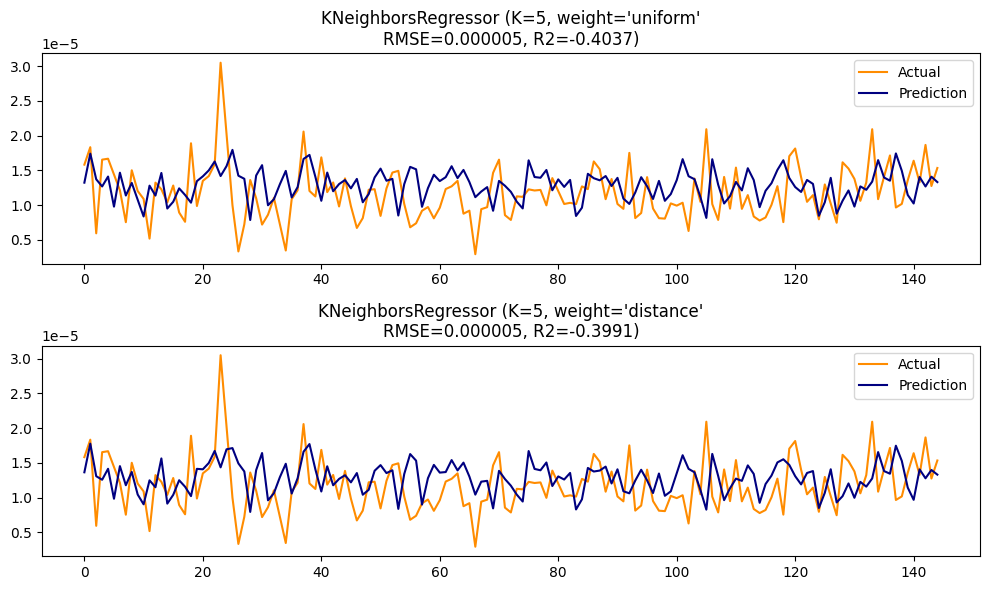

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = supervised[['NO2(t-4)', 'NO2(t-3)', 'NO2(t-2)', 'NO2(t-1)']]
y = supervised['NO2(t)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

n_neighbors = 5

plt.figure(figsize=(10, 6))

for i, weights in enumerate(['uniform', 'distance']):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    plt.subplot(2, 1, i + 1)
    plt.plot(range(len(y_test)), y_test, 'darkorange', label="Actual")
    plt.plot(range(len(y_pred)), y_pred, 'navy', label="Prediction")
    plt.title(f"KNeighborsRegressor (K={n_neighbors}, weight='{weights}'\nRMSE={rmse:.6f}, R2={r2:.4f})")
    plt.legend()
    plt.tight_layout()

plt.show()